In [ ]:
!pip install spacy
!pip install -U spacy-experimental
!pip install https://github.com/explosion/spacy-experimental/releases/download/v0.6.1/en_coreference_web_trf-3.4.0a2-py3-none-any.whl

# Описание

Очень давно хотела сделать что-нибудь, связанное с Дивергентом (книга Вероники Рот). "Чем-нибудь" стал дашборд по первой книге трилогии. Книгу удалось найти в свободном доступе на английском, поэтому дашборд на английском. Своеобразный трибьют тринадцатилетней мне, помешанной как на книгах, так и на фильмах по Дивергенту.

Помимо дашборда, построенного средствами flask, в данном блокноте можно найти рабочий код для разрешения кореференции и код построения красивых графов с использованием JS.

In [ ]:
# необходимые импорты

import re
import pandas as pd
import numpy as np
import itertools
from pandas.io.html import read_html
from skimage.io import imread

import spacy
from spacy.tokens import Doc
import spacy_experimental

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import hvplot.pandas
from IPython.display import display, HTML

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

import networkx as nx
from pyvis.network import Network
import matplotlib

nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

In [2]:
# глобальные переменные

factions = {"Abnegation": {"colormap": "gray", "color": "gray"},
            "Erudite": {"colormap": "Blues", "color": "cornflowerblue"},
            "Candor": {"colormap": "binary", "color": "black"},
            "Dauntless": {"colormap": "Reds", "color": "#e64f3c"},
            "Amity": {"colormap": "Greens", "color": "#75a630"},
            "Factionless": {"colormap": "Purples", "color": "#a054c7"}}

background_color = "white"

chapters = ["CHAPTER ONE", "CHAPTER TWO", "CHAPTER THREE", "CHAPTER FOUR", "CHAPTER FIVE", "CHAPTER SIX",
            "CHAPTER SEVEN", "CHAPTER EIGHT", "CHAPTER NINE", "CHAPTER TEN", "CHAPTER ELEVEN",
            "CHAPTER TWELVE", "CHAPTER THIRTEEN", "CHAPTER FOURTEEN", "CHAPTER FIFTEEN", "CHAPTER SIXTEEN",
            "CHAPTER SEVENTEEN", "CHAPTER EIGHTEEN", "CHAPTER NINETEEN", "CHAPTER TWENTY", "CHAPTER TWENTY-ONE",
            "CHAPTER TWENTY-TWO", "CHAPTER TWENTY-THREE", "CHAPTER TWENTY-FOUR", "CHAPTER TWENTY-FIVE",
            "CHAPTER TWENTY-SIX", "CHAPTER TWENTY-SEVEN", "CHAPTER TWENTY-EIGHT", "CHAPTER TWENTY-NINE",
            "CHAPTER THIRTY", "CHAPTER THIRTY-ONE", "CHAPTER THIRTY-TWO", "CHAPTER THIRTY-THREE",
            "CHAPTER THIRTY-FOUR", "CHAPTER THIRTY-FIVE", "CHAPTER THIRTY-SIX", "CHAPTER THIRTY-SEVEN",
            "CHAPTER THIRTY-EIGHT", "CHAPTER THIRTY-NINE"]  # именно в таком виде главы содержатся в книге

nlp = spacy.load("en_coreference_web_trf")  # get from https://github.com/explosion/spacy-experimental/releases/download/v0.6.1/en_coreference_web_trf-3.4.0a2-py3-none-any.whl
lemmatizer = WordNetLemmatizer()
sia = SentimentIntensityAnalyzer()

# Получение информации о персонажах

Информация о главных и второстепенных персонажей Дивергента берётся из Википедии. Так как речь идет только о первой книге трилогии, собранные имена фильтруются - остаются только те, для которых первое появление было в первой книге трилогии. Каждый персонаж представлен следующим образом: {"Character_name": {"Gender": str, "Original faction": str, "Faction": str}}. Ссылка: https://en.wikipedia.org/wiki/List_of_Divergent_characters

In [3]:
def dict_transformation(d):
    dvals = list(d.values())[0]
    if dvals['First appearance'] != 'Divergent':
        return None
    try:
        new_d = {list(d.keys())[0].replace('.1', '').replace('Mr.', '').replace('Mrs.', '').
                 replace('Beatrice', 'Tris').replace('Tobias', 'Four'). # Трис - это Беатрис, Фор - это Тобиас
                 split()[0]: {'Gender': dvals['Gender'],
                'Original faction': dvals['Original faction'],
                'Faction': dvals['Faction']}}
    except KeyError:
        new_d = {list(d.keys())[0].replace('.1', '').replace('Mr.', '').replace('Mrs.', '').
                 replace('Beatrice', 'Tris').replace('Tobias', 'Four').
                 split()[0]: {'Gender': dvals['Gender'],
                              'Original faction': dvals['Faction'],
                              'Faction': dvals['Faction']}}
    return new_d


page = 'https://en.wikipedia.org/wiki/List_of_Divergent_characters'
infoboxes = list(map(lambda box: box.to_dict(), read_html(page, index_col=0, attrs={"class": "infobox"})))  # информация содержится в infoboxes
print(f"Extracted {len(infoboxes)} infoboxes from Wikipedia page about Divergent.")

characters_info = list(filter(lambda item: item is not None, [dict_transformation(d) for d in infoboxes] +
                              [{"Marcus": {"Gender": "Male", "Original faction": "Abnegation", "Faction": "Abnegation"}}]))  # Маркус почему-то отсутствует на Википедии
characters_info = {list(item.keys())[0]:characters_info[i][list(item.keys())[0]] for i, item in enumerate(characters_info)
                   if list(item.keys())[0] not in ['Rose', 'Bud']}  # понятия не имею, откуда в Википедии эти двое - они даже не упоминаются в книге

print(f"There are {len(characters_info)} characters in Divergent Book I.")

Extracted 51 infoboxes from Wikipedia page about Divergent.
There are 32 characters in Divergent Book I.


In [4]:
character_names = list(characters_info.keys())  # запишем имена персонажей в отдельную переменную

# Разрешение кореференции

Книга написана от первого лица + в ней присутствует огромное количество диалогов с местоименными обращениями. Это вынуждает к предобработке текста.

In [28]:
text = open("books/Divergent.txt", 'r', encoding='utf-8').read()  # исходный текст книги

new_text = re.sub(r"(\W)Tobias(\W)", r"\1Four\2", re.sub(r"(\W)Beatrice(\W)", r"\1Tris\2", text))  # Трис - это Беатрис, Фор - это Тобиас
new_text = re.sub("my mother", "Natalie", re.sub("my father", "Andrew", re.sub("my brother", "Caleb", new_text)))  # назовем родственников Трис по именам

new_text = re.sub(r"\s+", " ", new_text)  # лишние пробелы

with open("books/Divergent_changed.txt", 'w', encoding='utf-8') as file:  # измененный текст книги
    file.write(new_text)

Разрешение кореференции по главам. Все местоимения, относящиеся к тому или иному персонажу, заменяются его именем. Каждая глава считается отдельным смысловым блоком. Используемый инструмент не идеален, но что есть.

In [24]:
# код отсюда: https://gist.github.com/thomashacker/b5dd6042c092e0a22c2b9243a64a2466

def resolve_references(doc: Doc) -> str:
    """Function for resolving references with the coref output
    doc (Doc): The Doc object processed by the coref pipeline
    RETURNS (str): The Doc string with resolved references
    """
    token_mention_mapper = {}
    output_string = ""
    clusters = [
        val for key, val in doc.spans.items() if key.startswith("coref_cluster")
    ]

    for cluster in clusters:
        flag = False
        for name in character_names:  # character names
            if flag:
                break
            for cluster_val in cluster:
                if str(cluster_val) == name:
                    first_mention = cluster_val
                    flag = True
                    break
        else:
            continue

        for mention_span in list(cluster)[1:]:
            token_mention_mapper[mention_span[0].idx] = first_mention.text + mention_span[0].whitespace_
            for token in mention_span[1:]:
                token_mention_mapper[token.idx] = ""

    for token in doc:
        if token.idx in token_mention_mapper:
            output_string += token_mention_mapper[token.idx]
        else:
            output_string += token.text + token.whitespace_

    return output_string

Тексты глав с разрешенной кореференцией сохраняются отдельно.

In [29]:
text = open("books/Divergent_changed.txt", 'r', encoding='utf-8').read()

prev_i = len(chapters[0])
for i in range(1, len(chapters)):
    found = text.find(chapters[i])
    chapter_text = resolve_references(nlp(text[prev_i:found].strip()))
    with open(f"books/chapters/{chapters[i-1]}.txt", 'w', encoding='utf-8') as file:
        file.write(chapter_text)
    prev_i = found + len(chapters[i])
chapter_text = resolve_references(nlp(text[prev_i + len(chapters[-1]):].strip()))

with open(f"books/chapters/{chapters[-1]}.txt", 'w', encoding='utf-8') as file:
    file.write(chapter_text)

Так как книга написана от первого лица, заменим все местоимения 'I', встречающиеся вне кавычек (то есть вне прямой речи) на 'Tris'.

In [33]:
for chapter in chapters:
    text = open(f"books/chapters/{chapter}.txt", 'r', encoding='utf-8').read()
    in_quotes = False
    replacements = 0
    i = -1
    try:
        while True:
            i = 3 * replacements + i + 1
            if text[i] == '\"':
                in_quotes = False if in_quotes else True
            if not in_quotes and text[i] == "I" and re.match(r"\W", text[i-1]) and re.match(r"\W", text[i+1]):
                text = text[:i] + "Tris" + text[i+1:]
    except IndexError:
        pass

    with open(f"books/chapters/{chapter}.txt", 'w', encoding='utf-8') as file:
        file.write(text)

# Частота встречаемости персонажей по главам (в процентах)

Все графики, использующиеся в дальнейшем для дашборда, строятся заранее (кэш) и потом просто используются в готовом виде по причине того, что их достаточно долго строить.

In [5]:
df = pd.DataFrame(index=character_names, columns=chapters)
df = df.fillna(0)

for chapter in chapters:
    with open(f"books/chapters/{chapter}.txt", "r", encoding='utf-8') as f:
        text = f.read()
        for character in character_names:
            count = text.count(character)
            df.at[character, chapter] = count

df = df.T

In [6]:
for name in character_names:
    person_info = pd.DataFrame({'Actual count': df[name], 'Percentage': df[name] / df[name].sum() * 100})
    person_info['Chapter'] = list(map(str, range(1, len(person_info) + 1)))

    try:
        color = factions[characters_info[name]['Faction']]['color']  # цвет графика зависит от фракции
    except KeyError:
        color = factions['Factionless']['color']

    line = person_info.hvplot.line(x='Chapter', y='Percentage',
                                   xlabel='Chapter', ylabel='Occurance Frequency', rot=90, color=color,
                                   ylim=(-3, 103))
    scatter = person_info.hvplot.scatter(x='Chapter', y='Percentage',
                                         hover_cols='all', use_index=False, color=color)
    plot = line * scatter
    hvplot.save(plot, f'templates/graphs_cached/frequencies/{name}.html', fmt='html')

Получившийся график показывает, насколько равномерно появляется персонаж на протяжении книги. Почему ось Y в процентах? Причина в разнице количества упоминаний того или иного персонажа. Так, Трис может появиться 152 раза за главу, а Тори всего 7.

In [19]:
# пример графика

with open("templates/graphs_cached/frequencies/Molly.html", mode='r', encoding='utf-8') as fp:
    html = fp.read()
display(HTML(html))

# Данные для облаков слов по персонажам

In [8]:
# стоп-слова под конкретный текст. имена персонажей тоже входят в стоп-слова

stopwords = stopwords.words('english') + \
            ["say", "know", "said", "look", "hand", "u", "see", "dont", "wouldnt", "shouldnt", "eye", "back",
             "trism", "marcuss", "christinas", "tell", "arm", "wa", "toris", "torus", "myra", "robert", "susans",
             "marlenes", "arm", "marcuse", "nose", "table", "one", "two", "next", "around", "across", "first",
             "toward", "go", "face", "second", "think", "erics", "shoulder", "stay"] + \
            list(map(lambda x: x.lower(), character_names))

Для построения используется следующая логика: идем по текстам глав окном шириной в три предложения (без наложений). Если в этих предложениях встречается имя персонажа, то добавляем к "словам персонажа" эти три предложения. Почему три? В книге очень много коротких предложений, одного предложения слишком мало для контекста.

In [33]:
character_sentences = {name: '' for name in character_names}

for chapter in chapters:
    with open(f"books/chapters/{chapter}.txt", "r", encoding='utf-8') as f:
        text = f.read()
    sentences = sent_tokenize(text)
    sentences = [" ".join(sentences[i:i+3]) for i in range(0, len(sentences), 3)]  # три предложения вместо одного
    for sentence in sentences:
        for name in character_names:
            if name in sentence:
                character_sentences[name] += sentence + ' '

character_words = {name: [] for name in character_names}

for name, sentences in character_sentences.items():
    words = word_tokenize(re.sub(r"[^a-zA-Z ]", "", sentences))  # очистка текста от лишних символов
    lemmatized_words = [lemmatizer.lemmatize(word.lower()) for word in words]   # лемматизация
    filtered_words = [word for word in lemmatized_words if not word in stopwords]  # выкидываем стоп-слова
    character_words[name] = filtered_words

    try:
        cmap = factions[characters_info[name]['Faction']]['colormap']  # цвет графика зависит от фракции
    except KeyError:
        cmap = factions['Factionless']['colormap']

    wordcloud = WordCloud(background_color=background_color,
                          colormap=cmap, width=400, height=200)
    wordcloud.generate(" ".join(filtered_words))
    wordcloud.to_file(f'static/wordclouds/{name}.png')

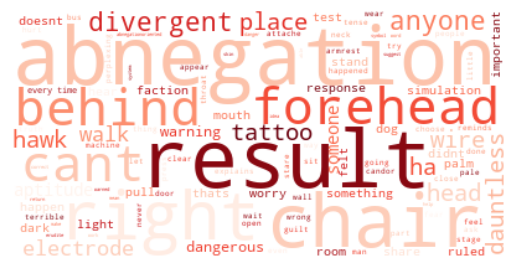

In [34]:
# пример графика

plt.imshow(imread('static/wordclouds/Tori.png'), interpolation='bilinear')
plt.axis("off")
plt.show()

# Данные для построения графа связей + анализ тональности

Построим граф отношений между сущностями. Вершины - персонажи. Размер вершин зависит от частоты встречаемости персонажа в книге, цвет - от того, к какой фракции персонаж принадлежит.

Будем считать, что если персонажи встречаются вместе, то между ними есть отношения. Характер отношений будем определять с помощью анализа тональности. Толщина ребер графа будет зависеть от того, насколько часто персонажи упоминаются вместе, а цвет - от усредненной тональности. Вообще, для Дивергента анализ тональности особо ничего не дал, тем не менее данный код можно использовать для любого другого текста.

Алгоритм такой: будем проходить по главам окном шириной в пять предложений и шагом в два. Для текущего окна будем получать все пары присутствующих в окне персонажей. Если пары есть и они не встретились на предыдущем шаге (ширина окна пять, шаг два, мы могли случайно захватить тех же), то добавляем +1 к "отношениям" персонажей, а также на основании текста окна вычисляем тональность этого отношения и прибавляем её к "тональности". В конце делим тональность на кол-во встреч персонажей и обнуляем её в том случае, если персонажи встретились менее трех раз.

In [11]:
def extract_characters(text):  # вытащить из текста все встречающиеся в нем имена персонажей
    return [name for name in character_names if text.find(name) != -1]

def get_pairs(lst):  # все сочетания длины 2 (пары)
    return list(itertools.combinations(lst, 2))

In [12]:
relationships = []

for chapter in chapters:

    text = open(f"books/chapters/{chapter}.txt", 'r', encoding='utf-8').read()
    sentences = sent_tokenize(text)
    prev_characters = []
    for i in range(0, len(sentences) - 5, 2):
        curr_sentences = sentences[i:i+5]
        characters = extract_characters(" ".join(curr_sentences))

        sentiment_scores = [sia.polarity_scores(s)['compound'] for s in curr_sentences]  # очень жесткое округление, иначе получается совсем чушь
        sentiment = 0
        if np.mean(sentiment_scores) > 0.1:
            sentiment = 1
        elif np.mean(sentiment_scores) < -0.1:
            sentiment = -1

        for pair in get_pairs(characters):
            c1, c2 = pair[0], pair[1]
            if not (c1 in prev_characters and c2 in prev_characters):
                relationships.append({"source": c1, "target": c2, "sentiment": sentiment})
        prev_characters = characters

In [13]:
relationship_df = pd.DataFrame(relationships)
relationship_df["value"] = 1
relationship_df = relationship_df.groupby(["source", "target"], sort=False, as_index=False).sum()
relationship_df['sentiment'] = relationship_df['sentiment'] / relationship_df['value']  # усредненные "отношения" между персонажами
relationship_df.loc[relationship_df['value'] < 3, 'sentiment'] = 0  # если персонажи пересеклись меньше 3 раз, будем считать, что между ними нейтральные отношения
relationship_df

,source,target,sentiment,value
0,Tris,Natalie,0.065217,46
1,Tris,Caleb,0.082474,97
2,Caleb,Natalie,0.200000,20
3,Tris,Andrew,0.095238,42
4,Caleb,Andrew,0.235294,17
...,...,...,...,...
185,Tris,Tessa,0.000000,1
186,Caleb,Tessa,0.000000,1
187,Susan,Tessa,0.000000,1
188,Peter,Marcus,0.200000,5


In [14]:
# базовый граф

G = nx.from_pandas_edgelist(relationship_df,
                            source = "source",
                            target = "target",
                            edge_attr = ["value", "sentiment"],
                            create_using = nx.Graph())

In [15]:
colors = {}
for name in character_names:
    try:
        color = factions[characters_info[name]['Faction']]['color']  # цвета вершин графа зависят от фракции
    except KeyError:
        color = factions['Factionless']['color']
    colors[name] = color

In [16]:
net = Network(notebook=True, bgcolor=background_color, cdn_resources='in_line')
net.repulsion()  # чтобы граф не дергался как бешеный
node_degree = dict(G.degree)
nx.set_node_attributes(G, node_degree, 'size')
nx.set_node_attributes(G, colors, 'faction')
net.from_nx(G)

cmap = plt.get_cmap('coolwarm')
norm = plt.Normalize(vmin=-1, vmax=1)
for edge in net.edges:
    edge["color"] = matplotlib.colors.to_hex(cmap(norm(edge['sentiment'])))  # цвет ребра графа зависит от степени теплоты отношений между инцидентными персонажами

# net.show("divergent.html")  не работает в DataSpell

In [17]:
for name in character_names:
    for node in net.nodes:
        node["color"] = node['faction']
        if node["id"] == name:
            node["color"] = "yellow"  # цвет вершины выбранного персонажа будет желтым

    html = net.generate_html()
    with open(f"templates/graphs_cached/graphs/{name}.html", mode='w', encoding='utf-8') as fp:
        fp.write(html)

In [18]:
# пример графа

with open("templates/graphs_cached/graphs/Jeanine.html", mode='r', encoding='utf-8') as fp:
    html = fp.read()
display(HTML(html))